In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn import svm
from sklearn import mixture
from sklearn.metrics import confusion_matrix
import glob
from helpers import ImageManager

In [2]:
# Get Data using the Helper Class
mng = ImageManager()
testing_images = mng.get_testing_images()
training_images = mng.get_training_images()
_, _ = mng.update_testing_bounds()
_, _ = mng.update_training_bounds()

In [3]:
"""
4.1 + 4.3 --- Training Images Feature Extraction using SIFT
"""

# plt.figure(figsize=(20, 80))
# for i in range(60):
        
#     # display images
#     plt.subplot(15, 4, (math.floor(i/15) + 1 + 4*(i%15))), plt.imshow(img_disp)
    
# plt.show()

'\n4.1 + 4.3 --- Training Images Feature Extraction using SIFT\n'

In [4]:
# [0, 16]
K = 15

[[  1.          15.5        115.5        ...   1.5          3.5
   18.5       ]
 [  2.           0.           0.         ...   1.           0.
    0.        ]
 [  2.25         3.75        46.5        ...   1.5          0.
    2.75      ]
 ...
 [ 38.8         22.8          9.4        ...   0.6          3.
    8.2       ]
 [ 46.75        43.25         9.75       ...  18.75         0.
    9.5       ]
 [ 92.66666667  79.33333333   6.         ...  37.           9.
   13.        ]]


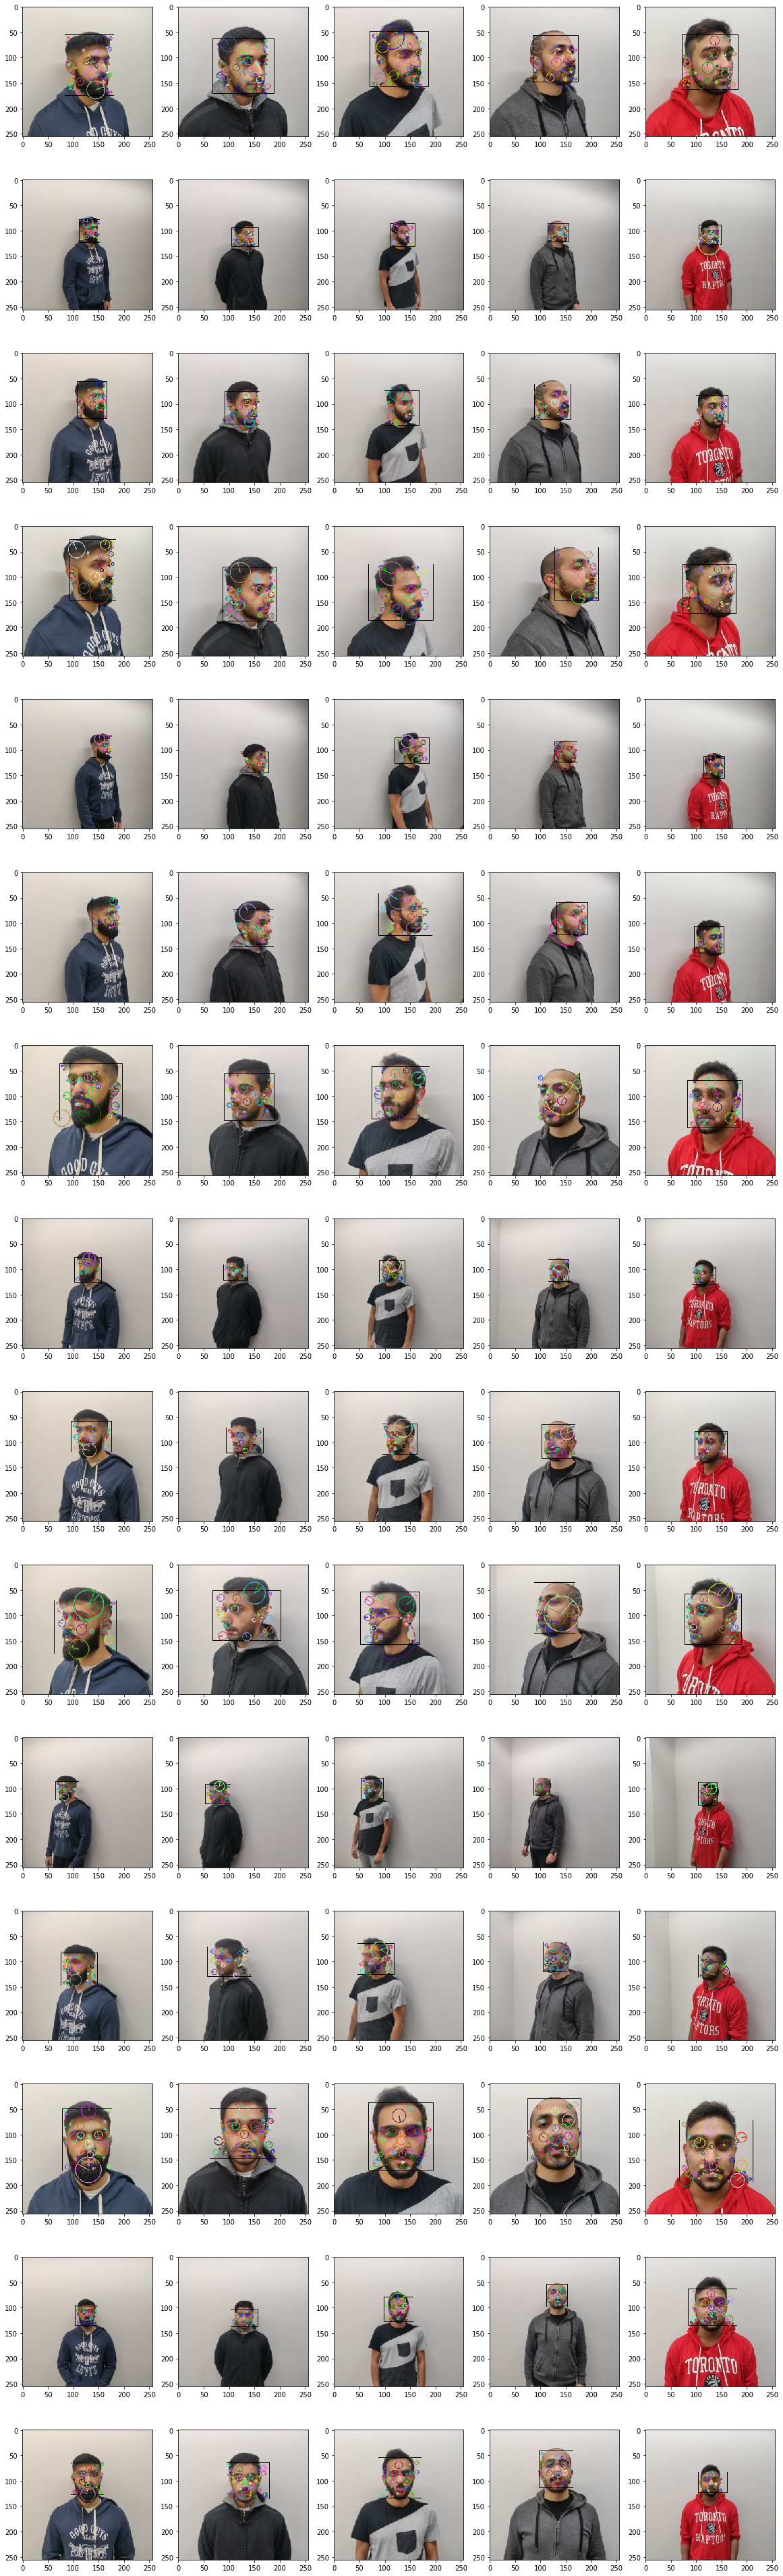

In [5]:
training_descriptors = []

plt.figure(figsize=(20, 70))
for i in range(75):
    img = training_images[i]
    
    img_disp = img.copy()

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)

    keypoints_filtered = []
    for kp in keypoints:
        point = kp.pt;
        if(point[0] > mng.training_bounds[i]["min_x"] and point[0] < mng.training_bounds[i]["max_x"] 
           and point[1] > mng.training_bounds[i]["min_y"] and point[1] < mng.training_bounds[i]["max_y"]):
            keypoints_filtered.append(kp)
    
    keypoints = keypoints_filtered

    # compute SIFT descriptors
    keypoints, descriptors = sift.compute(img, keypoints)
    
    clf = mixture.GaussianMixture(n_components = K, covariance_type='full', init_params = 'kmeans')

    # fit GMM on train data
    clf.fit(descriptors)
    
    # reference: https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
    clf.means_ = clf.means_[np.lexsort(np.fliplr(clf.means_).T)]
    
    if(i == 0):
        print(clf.means_)
    
    # predict cluster membership from the fitted GMM 
    labels = clf.predict(descriptors)
    
    descriptors_labels = {"descriptors" : descriptors, "labels" : labels}
    
    training_descriptors.append(descriptors_labels)
    
    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # display images
    plt.subplot(15, 5, (math.floor(i/15) + 1 + 5*(i%15))), plt.imshow(img_disp)
    
plt.show()

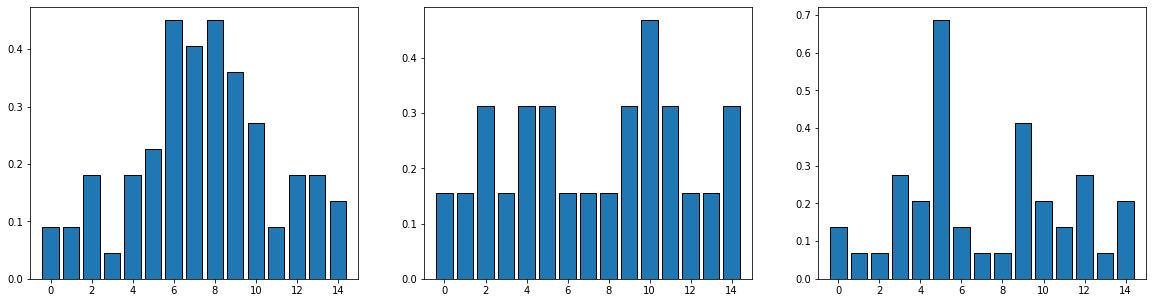

In [6]:
for i in range(75):
    freq = []
    for k in range(K):
        freq.append(np.count_nonzero(training_descriptors[i]["labels"] == k))
    
    training_descriptors[i]["histogram"] = freq/np.linalg.norm(freq)
    
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(K), training_descriptors[i]["histogram"], edgecolor='k' )
    plt.xlim([-1, K]) # set x-axis limit
plt.show()

In [7]:
# testing_bounds = []

# plt.figure(figsize=(20, 80))
# for i in range(56):
#     # display images
#     plt.subplot(14, 4, (math.floor(i/14) + 1 + 4*(i%14))), plt.imshow(img_disp)
    
# plt.show()

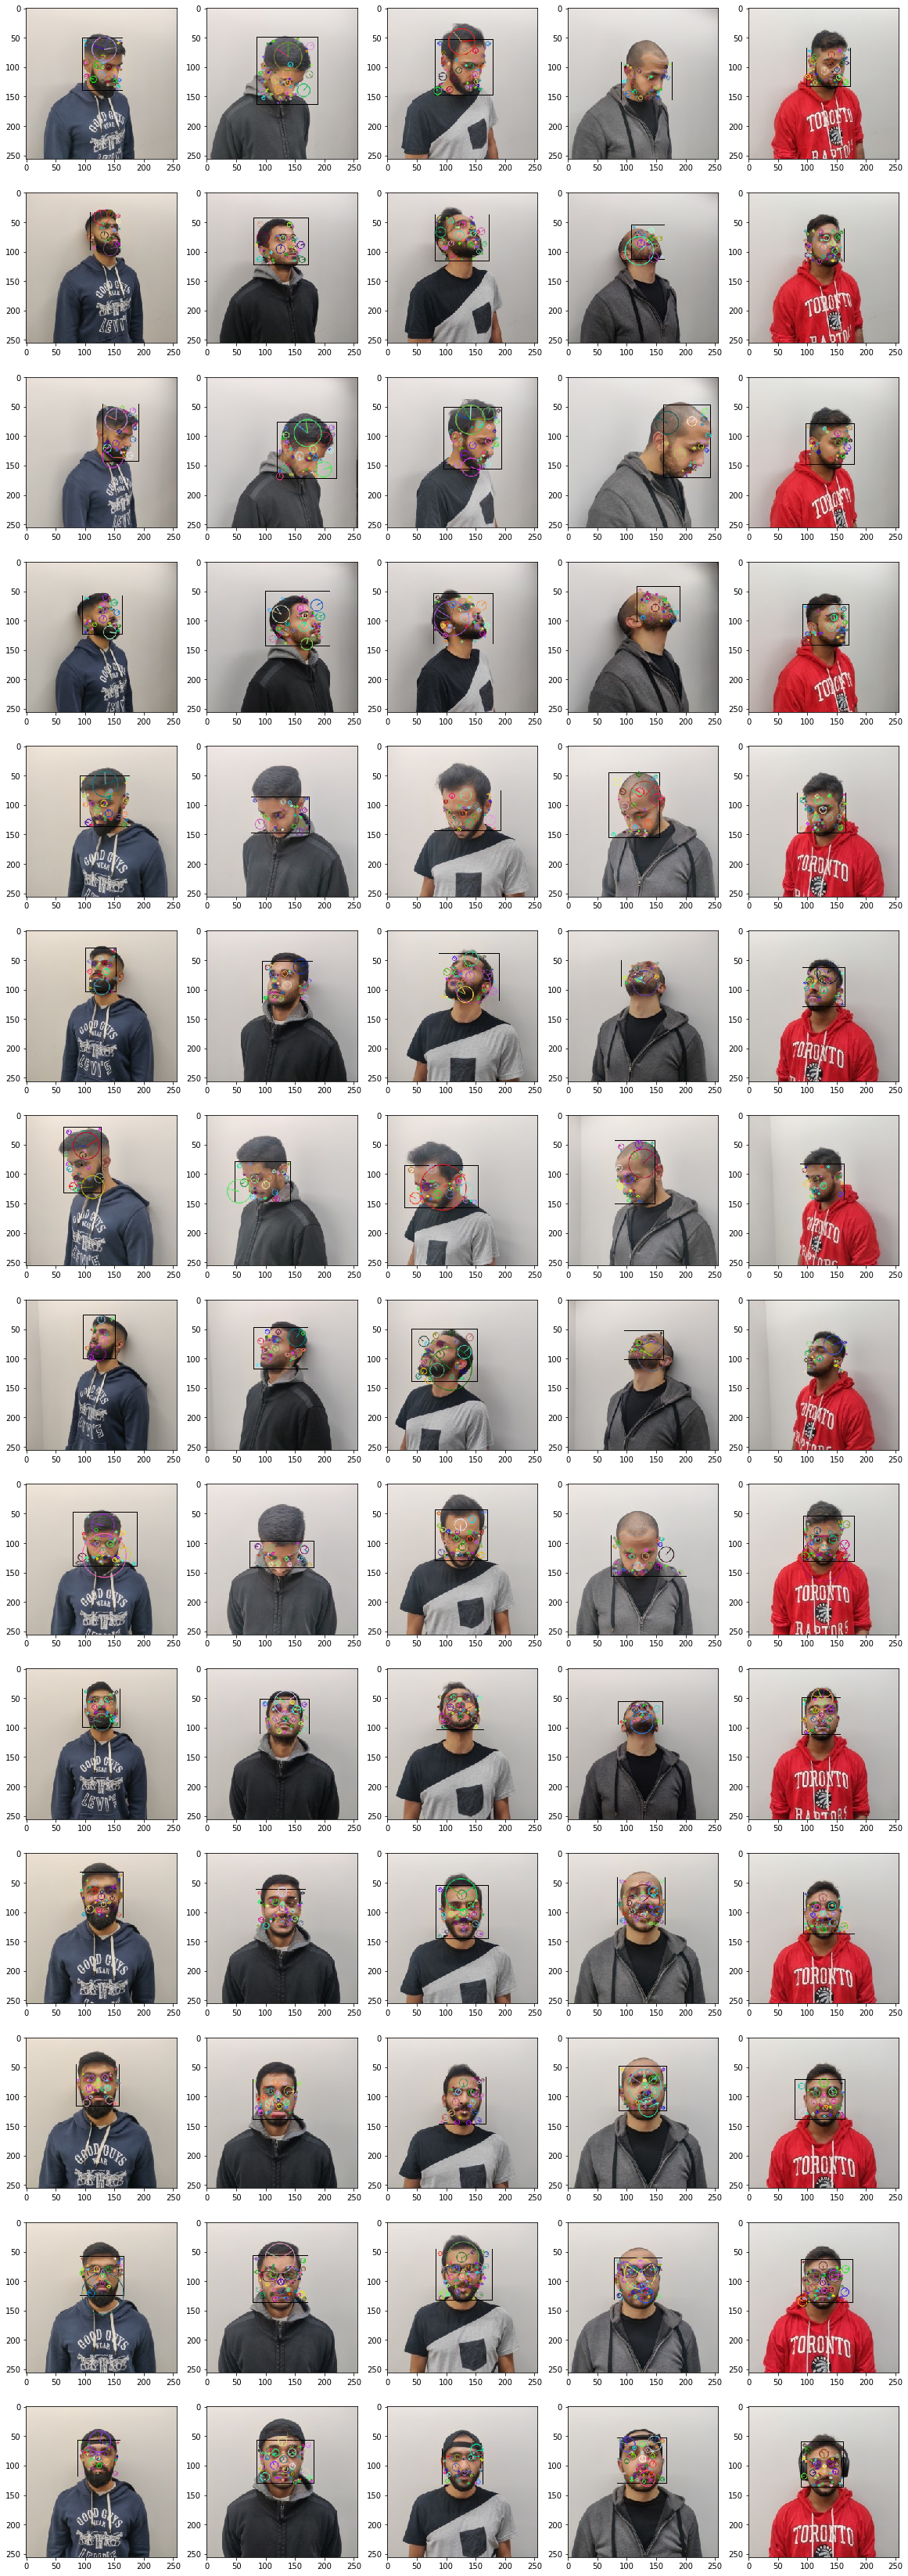

In [8]:
testing_descriptors = []

plt.figure(figsize=(20, 60))
for i in range(70):
    img = testing_images[i]
    
    img_disp = img.copy()

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)

    keypoints_filtered = []
    for kp in keypoints:
        point = kp.pt;
        if(point[0] > mng.testing_bounds[i]["min_x"] and point[0] < mng.testing_bounds[i]["max_x"] 
           and point[1] > mng.testing_bounds[i]["min_y"] and point[1] < mng.testing_bounds[i]["max_y"]):
            keypoints_filtered.append(kp)
    
    keypoints = keypoints_filtered

    # compute SIFT descriptors
    keypoints, descriptors = sift.compute(img, keypoints)
    
    clf = mixture.GaussianMixture(n_components = K, covariance_type='full', init_params = 'kmeans')

    # fit GMM on train data
    clf.fit(descriptors)
    
    # reference: https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
    clf.means_ = clf.means_[np.lexsort(np.fliplr(clf.means_).T)]

    # predict cluster membership from the fitted GMM 
    labels = clf.predict(descriptors)
    
    descriptors_labels = {"descriptors" : descriptors, "labels" : labels}
    
    testing_descriptors.append(descriptors_labels)
    
    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # display images
    plt.subplot(14, 5, (math.floor(i/14) + 1 + 5*(i%14))), plt.imshow(img_disp)    
    
plt.show()

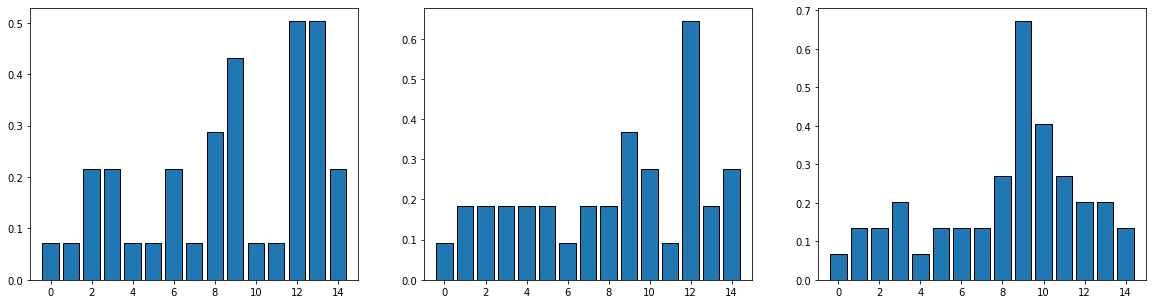

In [9]:
for i in range(70):
    freq = []
    for k in range(K):
        freq.append(np.count_nonzero(testing_descriptors[i]["labels"] == k))
    
    testing_descriptors[i]["histogram"] = freq/np.linalg.norm(freq)
    
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(K), testing_descriptors[i]["histogram"], edgecolor='k' )
    plt.xlim([-1, K]) # set x-axis limit
plt.show()

In [10]:
def difference(hist_1, hist_2):
    hist_1 = np.array(hist_1)
    hist_2= np.array(hist_2)
    diff = np.linalg.norm(hist_1 - hist_2)
    return diff

In [14]:
identities = []
for j, testing_descriptor in enumerate(testing_descriptors):
    closest_idx = 0
    min_diff = 1000
    diff = 0
    for i, training_descriptor in enumerate(training_descriptors):
        diff = difference(training_descriptor["histogram"], testing_descriptor["histogram"])
        if(diff < min_diff):
            min_diff = diff
            closest_idx = i
    
    if(closest_idx >= 0 and closest_idx < 15):
        identities.append("Abdullah")
    elif(closest_idx >= 15 and closest_idx < 30):
        identities.append("Mustafa")
    elif(closest_idx >= 30 and closest_idx < 45):
        identities.append("Saleh")
    elif(closest_idx >= 45 and closest_idx < 60):
        identities.append("Adham")
    else:
        identities.append("Anees")


In [15]:
ids = ["Abdullah", "Mustafa", "Saleh", "Adham", "Anees"]

true_ids = []
for id in ids:
    for i in range(14):
        true_ids.append(id)
    
correct = 0
for i in range(70):
    correct += identities[i] == true_ids[i]

correct

8